# Graphene band structure

This example plots the band structure of graphene, a 2D material. 2D band
structures are not supported natively (yet), so we manually build a custom
path in reciprocal space.

n     Energy            log10(ΔE)   log10(Δρ)   Diag
---   ---------------   ---------   ---------   ----
  1   -11.15661867741                   -0.60    6.0
  2   -11.16018127132       -2.45       -1.30    1.0
  3   -11.16040659161       -3.65       -2.30    2.9
  4   -11.16041656659       -5.00       -3.01    3.1
  5   -11.16041694022       -6.43       -3.29    3.3
Computing bands along kpath:
       Γ -> M -> K -> Γ
Diagonalising Hamiltonian kblocks: 100%|████████████████| Time: 0:00:04


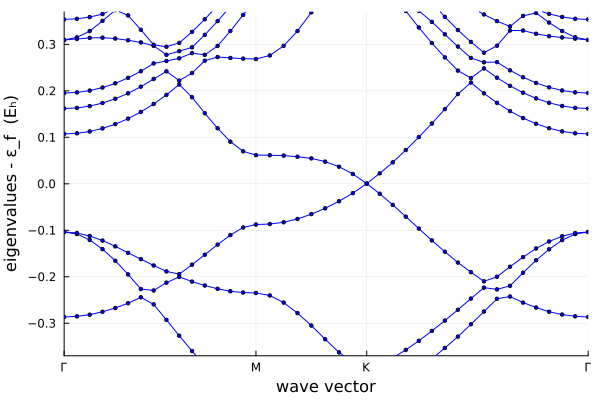

In [1]:
using DFTK
using Unitful
using UnitfulAtomic
using LinearAlgebra

# Define the convergence parameters (these should be increased in production)
L = 20  # height of the simulation box
kgrid = [6, 6, 1]
Ecut = 15
temperature = 1e-3

# Define the geometry and pseudopotential
a = 4.66  # lattice constant
a1 = a*[1/2,-sqrt(3)/2, 0]
a2 = a*[1/2, sqrt(3)/2, 0]
a3 = L*[0  , 0        , 1]
lattice = [a1 a2 a3]
C1 = [1/3,-1/3,0.0]  # in reduced coordinates
C2 = -C1
positions = [C1, C2]
C = ElementPsp(:C, psp=load_psp("hgh/pbe/c-q4"))
atoms = [C, C]

# Run SCF
model = model_PBE(lattice, atoms, positions; temperature)
basis = PlaneWaveBasis(model; Ecut, kgrid)
scfres = self_consistent_field(basis)

# Construct 2D path through Brillouin zone
sgnum = 13  # Graphene space group number
kpath = irrfbz_path(model; dim=2, sgnum)
plot_bandstructure(scfres, kpath; kline_density=20)